In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pickle

In [2]:
tf.__version__

'2.0.0'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
BUFFER_SIZE = 23
BATCH_SIZE = 5

In [5]:
from tqdm import tqdm
import cv2
def resize() -> None:
    drct = 'images/'
    new = 'new/g/'
    dims = (300, 200)
    for i in tqdm(os.listdir(drct)):
        img = cv2.imread(drct + i)
        img_new = cv2.resize(img, dims, interpolation=cv2.INTER_AREA)
        gray_image = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)
        cv2.imwrite('grey/' + i , gray_image)

In [6]:
def createds() -> None:
    drct = 'grey/'
    imgs = []
    for i in os.listdir(drct):
        img = cv2.imread(drct + i,1)
        img = img.astype('float32')
        img = (img - 127.5) / 127.5
        imgs.append(img)
        print(np.max(img), np.min(img))

    pickle.dump(np.array(imgs), open('train.pkl', 'wb'))

In [7]:
resize()


 96%|█████████████████████████████████████████████████████████████████████████████▋   | 23/24 [00:04<00:00,  5.58it/s]


error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [9]:
createds()

1.0 -0.5372549
1.0 -0.9372549
1.0 -0.9529412
1.0 -0.75686276
1.0 -0.85882354
1.0 -0.7882353
1.0 -0.31764707
1.0 -0.9843137
0.90588236 -0.94509804
1.0 -0.94509804
1.0 -0.7411765
1.0 -0.3254902
1.0 -0.88235295
0.9607843 -0.49019608
0.92941177 -0.654902
1.0 -0.6627451
1.0 -0.84313726
1.0 -0.9843137
1.0 -0.654902
1.0 -0.41960785
1.0 -0.8509804
0.99215686 -0.7490196
1.0 -0.7254902


In [10]:
df=pickle.load(open("train.pkl","rb"))

In [11]:
df.shape

(23, 200, 300, 3)

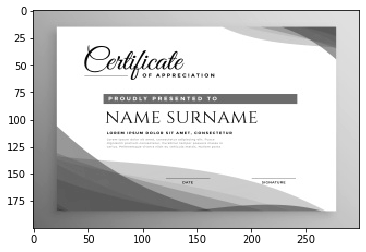

In [12]:
plt.imshow(df[4,:,:,0],cmap="gray")

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(df).shuffle(BUFFER_SIZE).batch(23)

In [14]:
train_dataset.window

<bound method DatasetV2.window of <BatchDataset shapes: (None, 200, 300, 3), types: tf.float32>>

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50*75*64, use_bias=False, input_shape=(1000,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((50, 75, 64)))
    assert model.output_shape == (None, 50, 75, 64) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 75, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 100, 150, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None,200 , 300, 3)

    return model

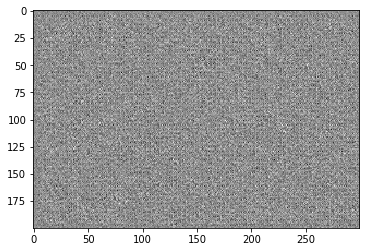

In [16]:
generator = make_generator_model()

noise = tf.random.normal([1, 1000])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[200, 300,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[7.126556e-05]], shape=(1, 1), dtype=float32)


In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
EPOCHS = 500
noise_dim = 1000
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('train/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

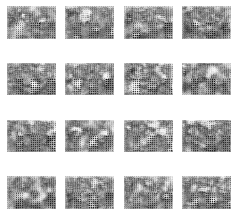

In [28]:
train(train_dataset, EPOCHS)

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [33]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('train/image_at_epoch_{:04d}.png'.format(epoch_no))

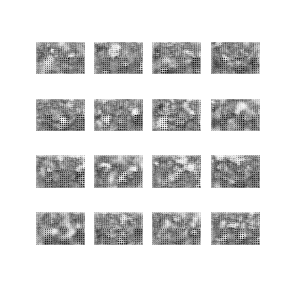

In [34]:
display_image(EPOCHS)

In [37]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('train/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)